In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set_context("notebook")
plt.rcParams.update({"axes.spines.right": False, "axes.spines.top": False, "legend.frameon": False})

In [2]:
df = pd.read_json("benchmarks-clang-10M.jsonl.gz", lines=True)
print(len(df), "rows")
for column in ["stdlib", "implementation", "count", "length"]:
    print(f"{column:<18} {df[column].unique().tolist()}")
implementation_order = df["implementation"].unique()

4608 rows
stdlib             ['libc++', 'libstdc++']
implementation     ['std::string', 'std::string_view', 'std::string_view (pool)', 'std::reference_wrapper']
count              [1048576]
length             [4, 6, 8, 11, 16, 23, 32, 45, 64]


In [3]:
dfm = (df.drop(columns=["compiler", "_result"])
    .groupby(["stdlib", "implementation", "count", "length"]).mean()
    .reset_index()
    .pipe(lambda d: d.assign(
        fill_rate=d["count"] / d.t_fill,
        query_rate=d["count"] / d.t_query,
        bytes_per_entry=d.map_size / d["count"],
    ))
)
print(len(dfm), "rows")

72 rows


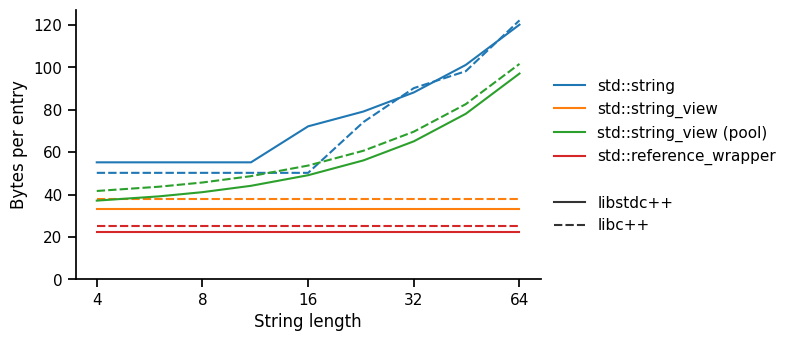

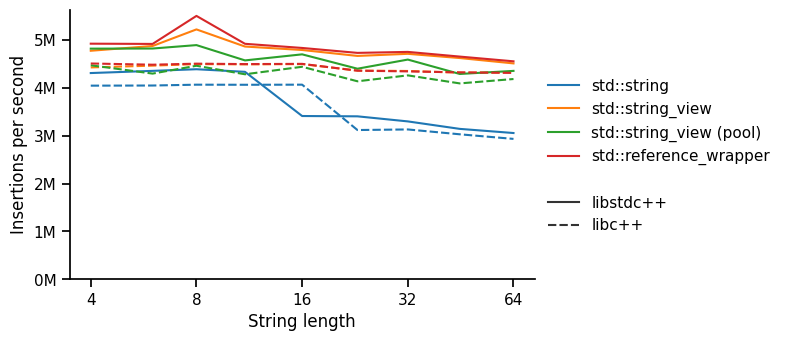

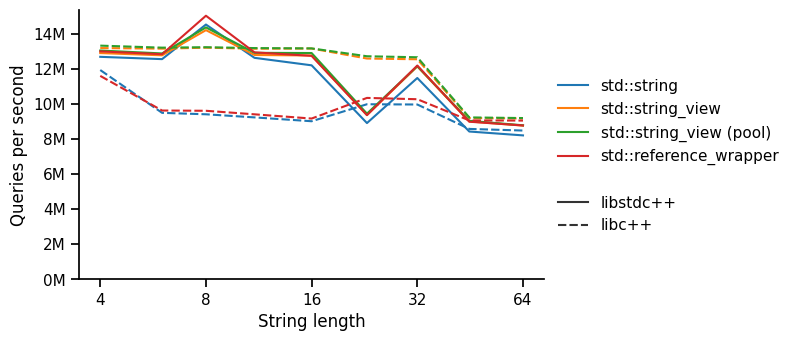

In [5]:
for y in ["bytes_per_entry", "fill_rate", "query_rate"]:
    plt.figure(figsize=(6, 3.5))
    ax = sns.lineplot(data=dfm, y=y, x="length", hue="implementation", hue_order=implementation_order, style="stdlib", style_order=["libstdc++", "libc++"])
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_ylim((0, ax.get_ylim()[1]))
    if "rate" in y:
        ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e6:.0f}M")
    hs, ls = ax.get_legend_handles_labels()
    ls = [s.replace("implementation", "").replace("stdlib", "") for s in ls]
    ax.legend(hs, ls, bbox_to_anchor=(1.0, 0.5), loc="center left")
    ax.set_xlabel("String length")
    ax.set_ylabel(dict(bytes_per_entry="Bytes per entry", fill_rate="Insertions per second", query_rate="Queries per second")[y])
    # plt.savefig(f"out/{y}.png", bbox_inches="tight")